In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from helpers import split_directive, filter_region_year, SNOV_FILTER

In [223]:
import statsmodels.formula.api as smf
import math


def get_significance(p):
    return "*" * sum(p < t for t in [0.05, 0.01, 0.001])


def format_p(p):
    return "<0.001***" if p < 0.001 else f"{p:.3g}{get_significance(p)}"


def itsa_friendly_df(snov: str, file_dir: Path = "podatki/df_mesecne.csv"):
    df = pd.read_csv(file_dir, parse_dates=["Datum"]).drop(columns="Postaja")
    df = filter_region_year(df, snov)

    def datum_range_mapping(df: pd.DataFrame, direktiva: str):
        datumi = sorted(df["Datum"].unique())
        time_mapping = pd.Series({m: i + 1 for i, m in enumerate(datumi)})

        return df["Datum"].map(time_mapping), time_mapping[direktiva].iloc[0]

    direktiva = SNOV_FILTER[snov]["direktiva"]

    time_values, prelomnica = datum_range_mapping(df, direktiva)
    df.insert(loc=2, column="Cas", value=time_values)

    df.insert(
        loc=3, column="Intervencija", value=(df["Datum"] >= direktiva).astype(int)
    )

    cas_po, _ = datum_range_mapping(df.loc[df["Intervencija"] == 1, :], direktiva)
    full_cas_po = pd.Series(0, index=df.index)
    full_cas_po.update(cas_po)
    df.insert(loc=4, column="Cas_po", value=full_cas_po)

    return df.drop(columns=["Datum"]), prelomnica


def create_itsa(
    df: pd.DataFrame,
    snov: str,
    prelomnica: int,
    ax: plt.axes,
    region: str = None,
):
    """
    Izvede analizo prekinjene časovne vrste in prikaže rezultate.

    Args:
        df: DataFrame s podatki (stolpci 'Cas', 'SO2', 'Intervencija', 'Cas po').
        snov: Ime snovi (npr. 'SO2').
        prelomnica: Časovna točka intervencije (v mesecih).
    """

    def plot_itsa(X, Y, b0, b1, b2, b3, prelomnica, snov):
        sns.set_theme()
        ax.scatter(X, Y, s=20, alpha=0.5, color="gray", label="Podatki")

        x_range = np.linspace(X.min(), X.max(), 100)
        x_before = x_range[x_range <= prelomnica]
        x_after = x_range[x_range >= prelomnica]

        ax.plot(
            x_before, b0 + b1 * x_before, color="blue", label="Trend pred intervencijo"
        )
        ax.plot(
            x_after,
            (b0 + b2) + b1 * prelomnica + (b1 + b3) * (x_after - prelomnica),
            color="red",
            label="Trend po intervenciji",
        )

        # Dodajanje navpične črte za prelomnico
        direktiva = SNOV_FILTER[snov]["direktiva"]
        ax.axvline(
            prelomnica,
            color="red",
            linestyle=(0, (1, 1)),
            label=f"NECD direktiva ({direktiva})",
        )

        reg_prefix = "Slovenija" if not region else region
        ax.set_title(
            f"{reg_prefix}",
            fontsize=14,
        )

    # 1. Izvedba regresije
    model = smf.ols(f"{snov} ~ Cas + Intervencija + Cas_po", data=df)
    results = model.fit()

    # 2. Ekstrakcija koeficientov
    b0 = results.params["Intercept"]
    b1 = results.params["Cas"]
    b2 = results.params["Intervencija"]
    b3 = results.params["Cas_po"]
    p_b2 = results.pvalues["Intervencija"]
    p_b3 = results.pvalues["Cas_po"]

    # 3. Ugotavljanje tipa učinka politike
    alpha = 0.05
    if p_b2 > alpha and p_b3 > alpha:
        policy_effect = "Ni učinka politike"
    elif p_b2 <= alpha and p_b3 > alpha:
        policy_effect = "Takojšnji učinek"
    elif p_b2 > alpha and p_b3 <= alpha:
        policy_effect = "Trajni učinek"
    else:
        policy_effect = "Takojšnji + trajni učinek"

    # 4. Priprava podatkov za graf
    X = df["Cas"].values
    Y = df[snov].values

    plot_itsa(X, Y, b0, b1, b2, b3, prelomnica, snov)

    """ text = (
        f"**Rezultati analize:**\n"
        f"- Takojšnji učinek (b2): {b2:.3f} (p={format_p(p_b2)})\n"
        f"- Trajni učinek (b3): {b3:.3f} (p={format_p(p_b3)})\n"
        f"- Tip učinka politike: {policy_effect}\n"
    """  

    results_df = pd.DataFrame(
        {
            "Takojšnji učinek": [round(b2,1)],
            "Takojšnji učinek (p-vrednost)": [format_p(p_b2)],
            "Trajni učinek": [round(b3,1)],
            "Trajni učinek (p-vrednost)": [format_p(p_b3)],
            "Tip učinka politike": [policy_effect],
        },
        index=[region or "Slovenija"],
    )

    return results_df


In [224]:
def itsa_wrapper(file_dir: Path, snov: str, data_type: str):
    prepared_df, prelomnica = itsa_friendly_df(snov, file_dir)
    regije = (prepared_df["Regija"].unique()).tolist()
    ncols = 2
    nrows = math.ceil((len(regije) + 1) / ncols)

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 10))
    axes = axes.flatten()

    handles, labels = [], []

    all_results = [] 

    for i, regija in enumerate(regije):
        regija_df = prepared_df.loc[prepared_df["Regija"] == regija]
        ax = axes[i]
        itsa_return = create_itsa(regija_df, snov, prelomnica, ax, regija)
        all_results.append(itsa_return)
        h, l = ax.get_legend_handles_labels()
        if i == 0:
            handles.extend(h)
            labels.extend(l)

    slovenia_results = create_itsa(prepared_df, snov, prelomnica, axes[len(regije)], "Slovenija")
    all_results.append(slovenia_results)

    fig.legend(handles, labels, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.05))

    fig.supxlabel("Čas (v mesecih)")
    if data_type == "leto":
        fig.supylabel(f"mesečni nivo {snov} μg/m3")
    elif data_type == "dan":
        fig.supylabel(f"(najvišji) dnevni nivo {snov} μg/m3")
    else:
        fig.supylabel(f"(najvišji) urni nivo {snov} μg/m3")
    fig.suptitle(f"Analiza prekinjene časovne vrste - {snov}")

    for i in range(len(regije) + 1, len(axes)):
        axes[i].remove()

    plt.tight_layout()  # Adjust rect to make space for the legend and
    plt.show()

    full_result = pd.concat(all_results)
    full_result.columns = pd.MultiIndex.from_product([[data_type + " meritve"], full_result.columns])

    return full_result



In [225]:
table_mapper = {
    "ura meritve": "(najvišje) urne meritve",
    "dan meritve": "(najvišje) dnevne meritve",
    "leto meritve": "mesečne meritve"
}

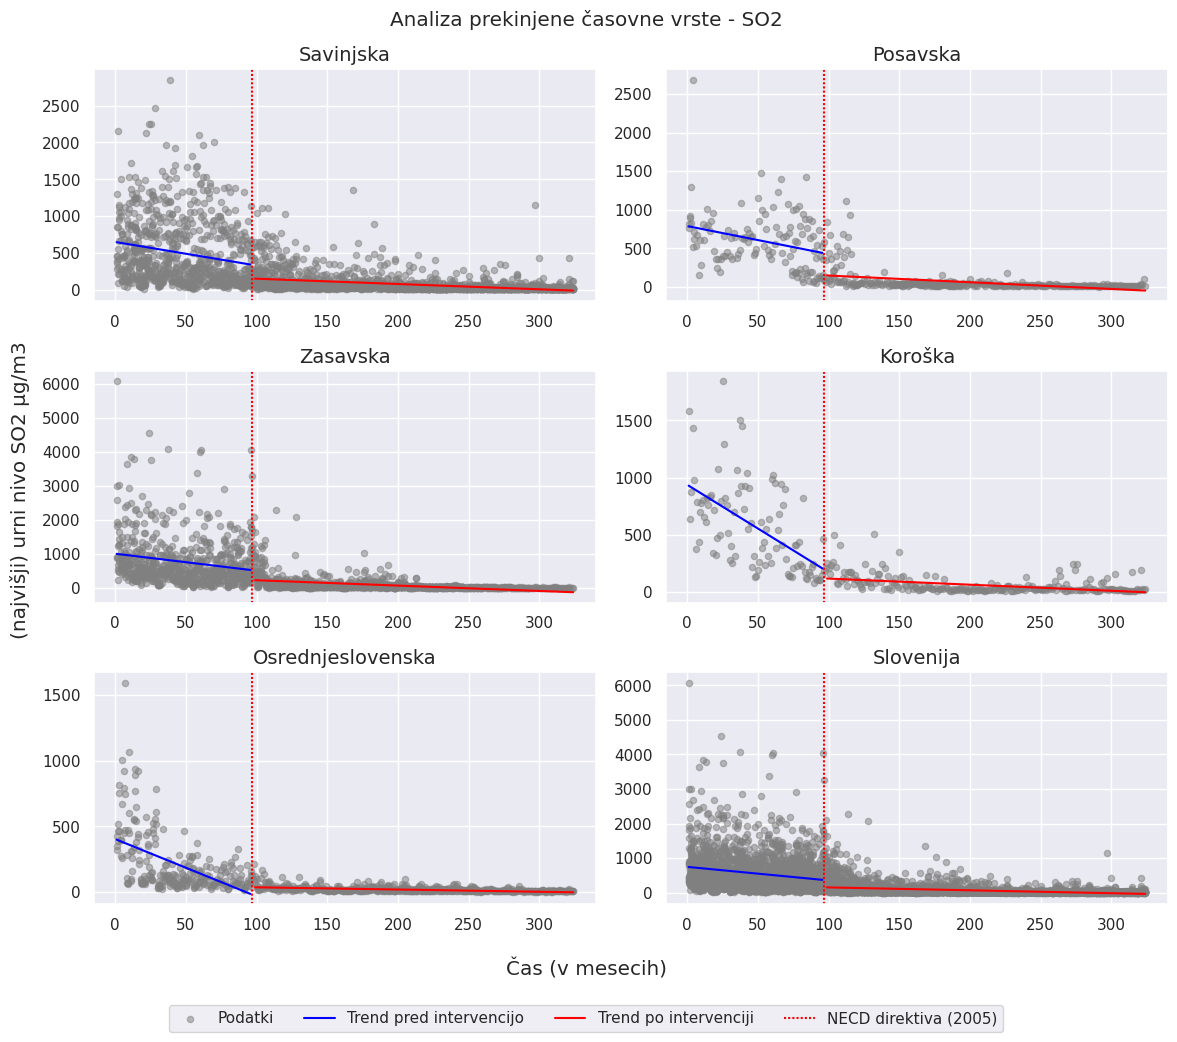

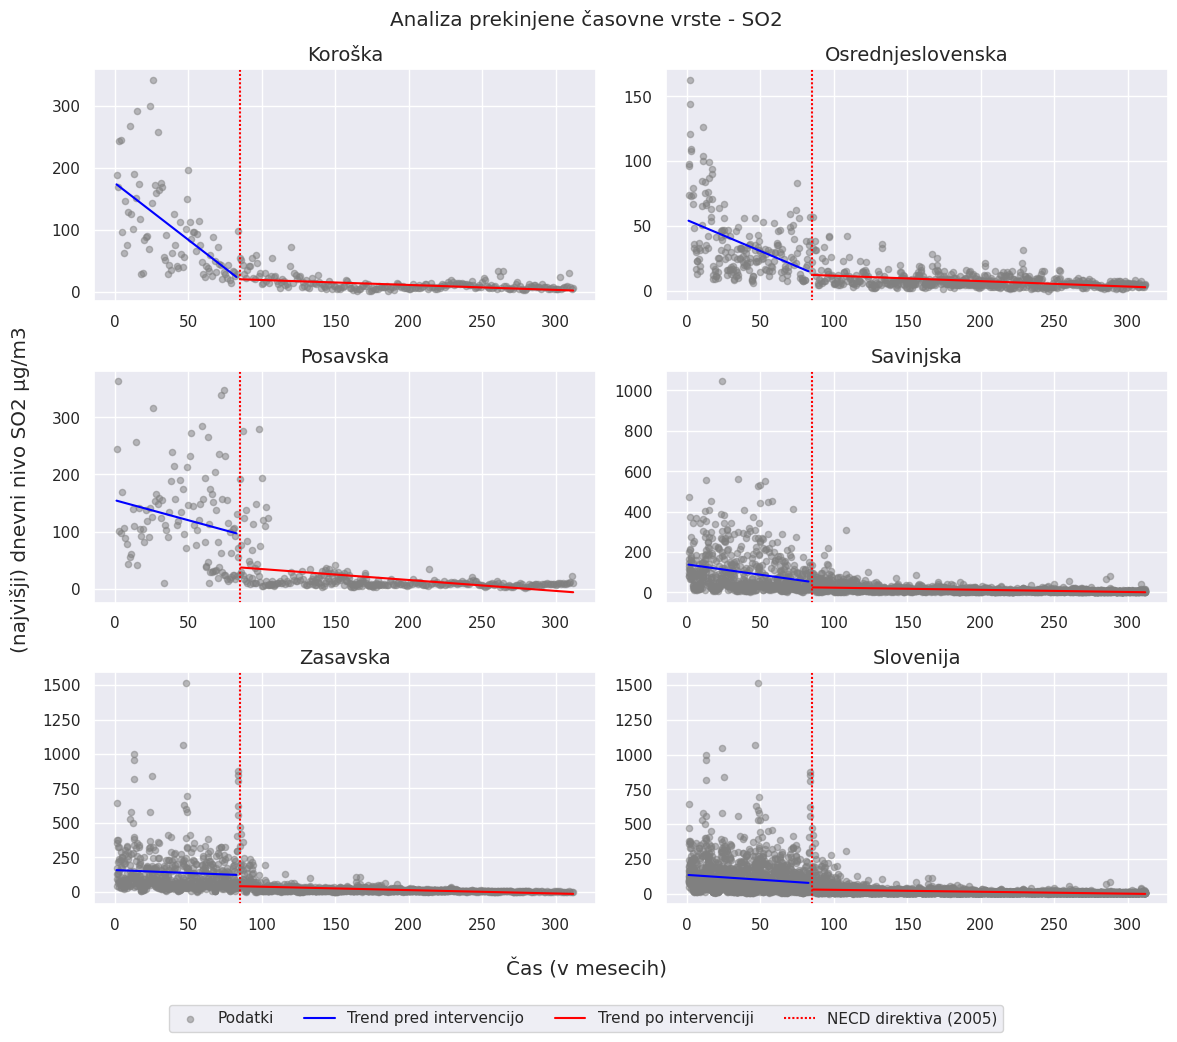

(najvišje) urne meritve                                \
                         Takojšnji učinek Takojšnji učinek (p-vrednost)   
Savinjska                          -186.2                     <0.001***   
Posavska                           -286.1                     <0.001***   
Zasavska                           -290.5                     <0.001***   
Koroška                             -77.2                        0.0842   
Osrednjeslovenska                    56.7                     0.00175**   
Slovenija                          -211.3                     <0.001***   

                                                            \
                  Trajni učinek Trajni učinek (p-vrednost)   
Savinjska                   2.5                  <0.001***   
Posavska                    2.8                  <0.001***   
Zasavska                    3.4                  <0.001***   
Koroška                     7.1                  <0.001***   
Osrednjeslovenska           4.2                  <0.001***   
Slovenija                   3.1                  <0.001***   

                                             (najvišje) dnevne meritve  \
                         Tip učinka politike          Takojšnji učinek   
Savinjska          Takojšnji + trajni učinek                     -26.7   
Posavska           Takojšnji + trajni učinek                     -58.0   
Zasavska           Takojšnji + trajni učinek                     -81.0   
Koroška                        Trajni učinek                       0.6   
Osrednjeslovenska  Takojšnji + trajni učinek                      -1.7   
Slovenija          Takojšnji + trajni učinek                     -46.3   

                                                               \
                  Takojšnji učinek (p-vrednost) Trajni učinek   
Savinjska                             <0.001***           0.9   
Posavska                              <0.001***           0.5   
Zasavska                              <0.001***           0.2   
Koroška                                   0.943           1.8   
Osrednjeslovenska                          0.48           0.4   
Slovenija                             <0.001***           0.6   

                                                                         
                  Trajni učinek (p-vrednost)        Tip učinka politike  
Savinjska                          <0.001***  Takojšnji + trajni učinek  
Posavska                           0.00783**  Takojšnji + trajni učinek  
Zasavska                               0.283           Takojšnji učinek  
Koroška                            <0.001***              Trajni učinek  
Osrednjeslovenska                  <0.001***              Trajni učinek  
Slovenija                          <0.001***  Takojšnji + trajni učinek

In [230]:
df_hourly = itsa_wrapper(Path("podatki/df_urne.csv"), "SO2", "ura")
df_daily = itsa_wrapper(Path("podatki/df_dnevne.csv"), "SO2", "dan")

combined_df = pd.concat([df_hourly,df_daily],axis=1).rename(columns=table_mapper)
combined_df.to_csv("tmp_ITSA_SO2.csv")
combined_df


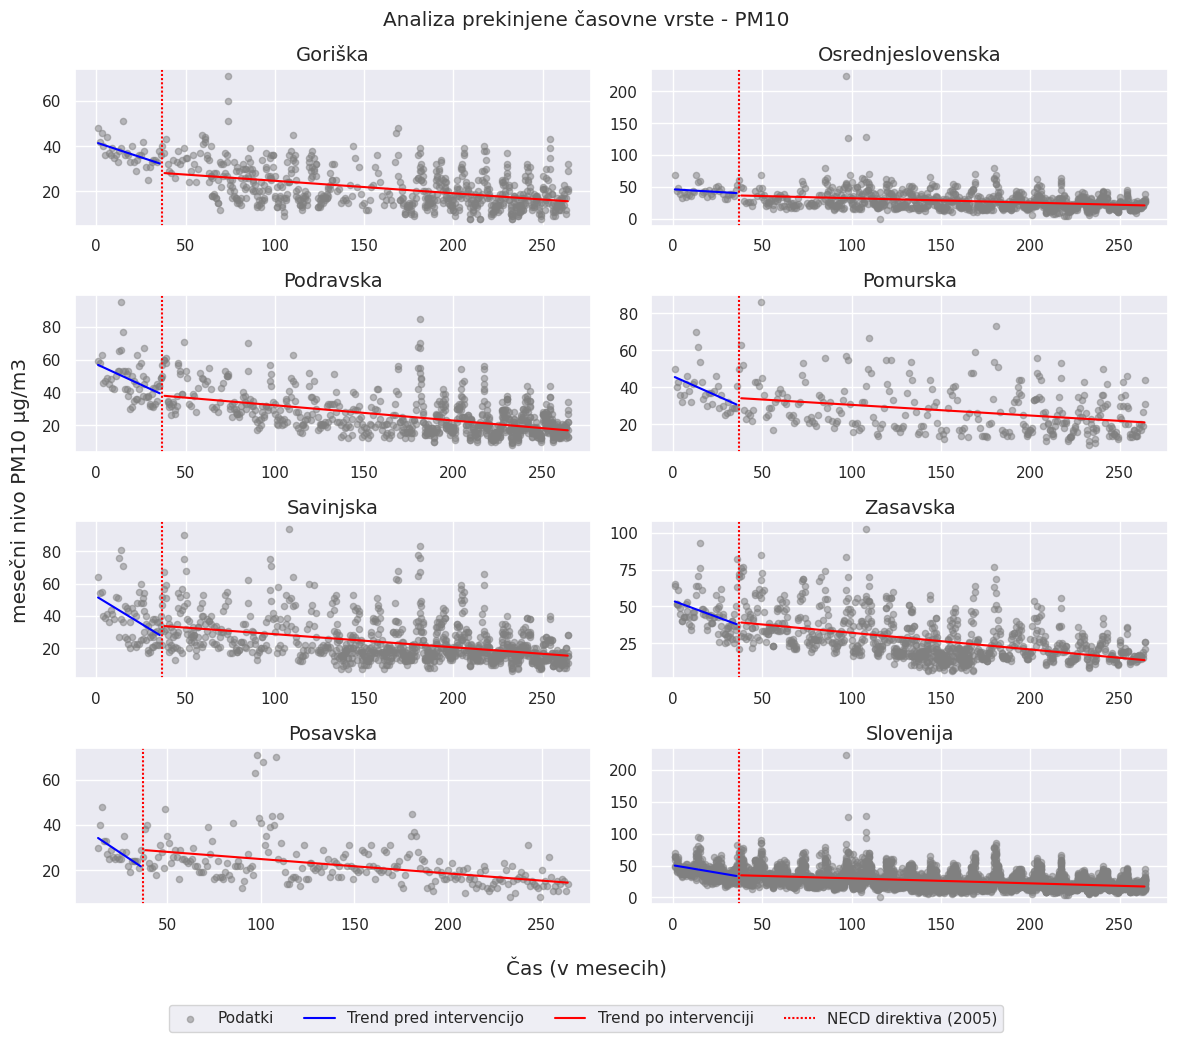

mesečne meritve                                \
                  Takojšnji učinek Takojšnji učinek (p-vrednost)   
Goriška                       -3.8                         0.146   
Osrednjeslovenska             -3.5                         0.447   
Podravska                     -0.7                          0.79   
Pomurska                       4.1                         0.323   
Savinjska                      6.6                     0.00909**   
Zasavska                       1.9                         0.478   
Posavska                       7.9                        0.027*   
Slovenija                      1.8                         0.136   

                                                            \
                  Trajni učinek Trajni učinek (p-vrednost)   
Goriška                     0.2                     0.0964   
Osrednjeslovenska           0.1                      0.656   
Podravska                   0.4                  0.00199**   
Pomurska                    0.4                    0.0493*   
Savinjska                   0.6                  <0.001***   
Zasavska                    0.3                    0.0122*   
Posavska                    0.5                     0.0532   
Slovenija                   0.4                  <0.001***   

                                              
                         Tip učinka politike  
Goriška                   Ni učinka politike  
Osrednjeslovenska         Ni učinka politike  
Podravska                      Trajni učinek  
Pomurska                       Trajni učinek  
Savinjska          Takojšnji + trajni učinek  
Zasavska                       Trajni učinek  
Posavska                    Takojšnji učinek  
Slovenija                      Trajni učinek

In [228]:
df_yearly = itsa_wrapper(Path("podatki/df_mesecne.csv"), "PM10", "leto").rename(columns=table_mapper)

df_yearly

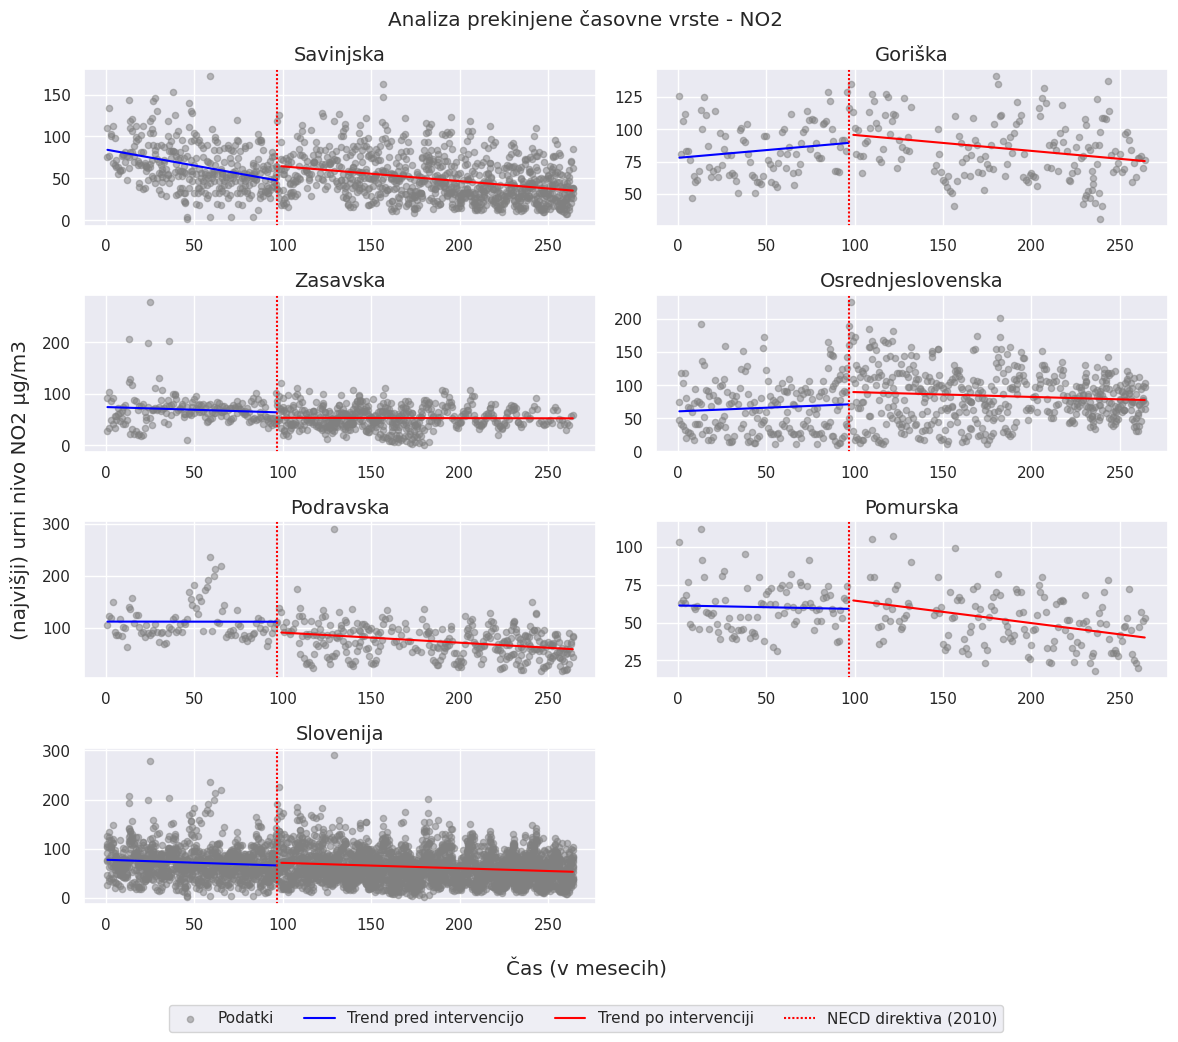

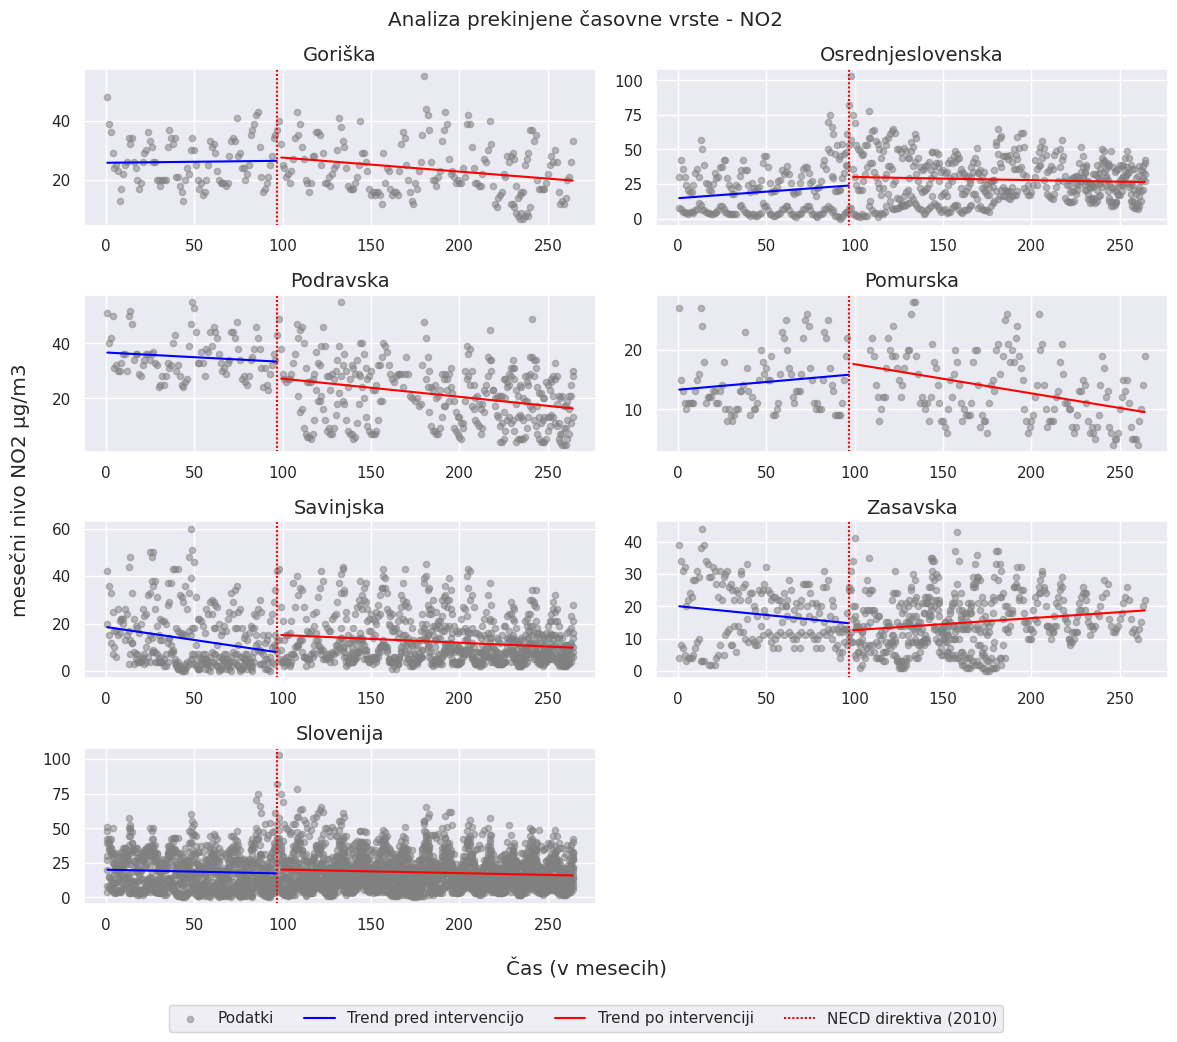

(najvišje) urne meritve                                \
                         Takojšnji učinek Takojšnji učinek (p-vrednost)   
Savinjska                            17.4                     <0.001***   
Goriška                               6.5                         0.246   
Zasavska                            -10.7                     0.00819**   
Osrednjeslovenska                    18.7                     0.00211**   
Podravska                           -20.4                     0.00574**   
Pomurska                              5.9                         0.191   
Slovenija                             5.7                       0.0153*   

                                                            \
                  Trajni učinek Trajni učinek (p-vrednost)   
Savinjska                   0.2                  <0.001***   
Goriška                    -0.2                   0.0049**   
Zasavska                    0.1                      0.143   
Osrednjeslovenska          -0.2                     0.0673   
Podravska                  -0.2                      0.111   
Pomurska                   -0.1                     0.0582   
Slovenija                   0.0                      0.807   

                                              mesečne meritve  \
                         Tip učinka politike Takojšnji učinek   
Savinjska          Takojšnji + trajni učinek              7.3   
Goriška                        Trajni učinek              1.2   
Zasavska                    Takojšnji učinek             -2.2   
Osrednjeslovenska           Takojšnji učinek              6.2   
Podravska                   Takojšnji učinek             -6.0   
Pomurska                  Ni učinka politike              1.9   
Slovenija                   Takojšnji učinek              2.8   

                                                               \
                  Takojšnji učinek (p-vrednost) Trajni učinek   
Savinjska                             <0.001***           0.1   
Goriška                                   0.564          -0.1   
Zasavska                                  0.115           0.1   
Osrednjeslovenska                       0.0146*          -0.1   
Podravska                             0.00822**          -0.0   
Pomurska                                  0.168          -0.1   
Slovenija                             0.00245**           0.0   

                                                                         
                  Trajni učinek (p-vrednost)        Tip učinka politike  
Savinjska                          <0.001***  Takojšnji + trajni učinek  
Goriška                                0.106         Ni učinka politike  
Zasavska                           <0.001***              Trajni učinek  
Osrednjeslovenska                  0.00506**  Takojšnji + trajni učinek  
Podravska                              0.393           Takojšnji učinek  
Pomurska                           <0.001***              Trajni učinek  
Slovenija                              0.898           Takojšnji učinek

In [229]:
df_hourly = itsa_wrapper(Path("podatki/df_urne.csv"), "NO2", "ura")
df_yearly = itsa_wrapper(Path("podatki/df_mesecne.csv"), "NO2", "leto")

combined_df = pd.concat([df_hourly,df_yearly],axis=1).rename(columns=table_mapper)
display(combined_df)